In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from plato.planets.metrics import PlanetPopulationMetrics
from plato.planets.populations import PopulationModel
from plato.stars import filter_valid_targets
from plato.visualisation import FigureProcessor, get_palette, set_plot_defaults
from plato.utils import get_abspath

In [3]:
set_plot_defaults()

figure_directory = f"/figures/07_planet_population_metrics/"
save = True

In [4]:
LOPS2 = pd.read_csv(get_abspath() + f"data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(get_abspath() + f"data/processed/LOPN1_targets.csv")

fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(fields)
fields = fields[
    [
        "Radius",
        "Mass",
        "[Fe/H]",
        "u1",
        "u2",
        "gaiaV",
        "n_cameras",
        "Population",
    ]
]

fields["cos_i"] = 0
fields["sigma_star"] = 10e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

In [5]:
metrics = PlanetPopulationMetrics()

## Recreate NGPPS II Table 7

In [6]:
metric_table = {}

for num_embryos in [10, 20, 50, 100]:
    population_model = PopulationModel(
        fields,
        num_embryos=num_embryos,
        additional_columns=["Population"],
    )

    mock = population_model.create_mock_population(additional_columns=["Population"])

    table = metrics.calculate_metrics(
        mock,
        by_population=True,
        number_of_systems={
            pop: len(fields[fields["Population"] == pop])
            for pop in fields["Population"].unique()
        },
    )
    metric_table[num_embryos] = table

metric_table = (
    pd.concat(metric_table, axis=1)
    .reindex(
        index=pd.MultiIndex.from_product(
            [
                [
                    "Thin Disk",
                    # "Thick Disk Candidate",
                    "Thick Disk",
                    # "Halo Candidate",
                    "Halo",
                ],
                ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
            ],
        )
    )
    .round(3)
)

In [7]:
metric_table

10                                   \
                       Number of Planets System Fraction Occurrence Rate   
Thin Disk  Earth                  192501           0.561           1.118   
           Super-Earth            247984           0.690           1.440   
           Neptunian               60649           0.289           0.352   
           Sub-Giant               25111           0.138           0.146   
           Giant                   46449           0.182           0.270   
Thick Disk Earth                    9093           0.567           1.055   
           Super-Earth             15908           0.759           1.845   
           Neptunian                2800           0.262           0.325   
           Sub-Giant                1742           0.196           0.202   
           Giant                    1957           0.149           0.227   
Halo       Earth                     445           0.571           0.895   
           Super-Earth              1302           0.911           2.620   
           Neptunian                  84           0.145           0.169   
           Sub-Giant                 166           0.332           0.334   
           Giant                      41           0.058           0.082   

                                                  20                   \
                       Multiplicity Number of Planets System Fraction   
Thin Disk  Earth              1.992            353567           0.651   
           Super-Earth        2.086            341949           0.751   
           Neptunian          1.218             64908           0.309   
           Sub-Giant          1.059             20486           0.099   
           Giant              1.481             47820           0.182   
Thick Disk Earth              1.861             17832           0.663   
           Super-Earth        2.431             19336           0.807   
           Neptunian          1.242              3432           0.332   
           Sub-Giant          1.030              1151           0.104   
           Giant              1.524              1913           0.147   
Halo       Earth              1.567               926           0.628   
           Super-Earth        2.874              1319           0.932   
           Neptunian          1.167               210           0.388   
           Sub-Giant          1.006                60           0.076   
           Giant              1.414                33           0.044   

                                                                  50   \
                       Occurrence Rate Multiplicity Number of Planets   
Thin Disk  Earth                 2.053        3.155            659788   
           Super-Earth           1.986        2.645            537073   
           Neptunian             0.377        1.219             56032   
           Sub-Giant             0.119        1.200             15518   
           Giant                 0.278        1.527             42979   
Thick Disk Earth                 2.068        3.121             35459   
           Super-Earth           2.242        2.780             19860   
           Neptunian             0.398        1.198              1691   
           Sub-Giant             0.133        1.283               458   
           Giant                 0.222        1.509              1140   
Halo       Earth                 1.863        2.968              1888   
           Super-Earth           2.654        2.849               518   
           Neptunian             0.423        1.088                23   
           Sub-Giant             0.121        1.579                 3   
           Giant                 0.066        1.500                13   

                                                                     \
                       System Fraction Occurrence Rate Multiplicity   
Thin Disk  Earth                 0.807           3.832        4.748   
           Super-Earth           0.717         

In [16]:
# calculate the total number of planets
total_planet_number = (
    pd.DataFrame(
        metric_table[((n, "Number of Planets") for n in [10, 20, 50, 100])]
        .sum(axis=0)
        .reset_index(level=1, drop=True),
    )
    .rename(columns={0: "Total Number of Planets"})
    .rename_axis("Number of Embryos")
)
total_planet_number

,Total Number of Planets
Number of Embryos,
10,606232
20,874942
50,1372443
100,1651019


## GET UNCERTAINTIES FOR HALO PLANETS, ALSO METALLICITY CUT

In [9]:
halo_table = defaultdict(dict)

for num_embryos in [10, 20, 50, 100]:
    for metallicity_name, metallicity_cut in {
        "Halo (Without [Fe/H] Cut)": None,
        "Halo (With [Fe/H] Cut)": -0.6,
    }.items():
        halo_population_model = PopulationModel(
            fields[fields["Population"] == "Halo"],
            num_embryos=num_embryos,
            additional_columns=["Population"],
        )

        halo_mocks = [
            halo_population_model.create_mock_population(
                additional_columns=["Population"],
                metallicity_limit=metallicity_cut,
            )
            for _ in range(300)
        ]

        halo_metrics = [
            metrics.calculate_number_of_planets(
                mock,
            )
            for mock in halo_mocks
        ]

        halo_metrics_stats = metrics.calculate_metrics_stats(
            halo_metrics,
            grouping_column="Planet Category",
            format_uncertainties=True,
            round_decimals="ceil",
            to_int=True,
            new_col_name="",
        )

        halo_table[num_embryos][metallicity_name] = halo_metrics_stats

halo_table = pd.concat(
    {key: pd.concat(val, axis=0) for key, val in halo_table.items()},
    axis=1,
)
halo_table.columns = halo_table.columns.droplevel(1)
halo_table = halo_table.reindex(
    ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
    level=1,
)

In [10]:
num_planets = (
    metric_table[:]["Number of Planets"]
    .drop(
        index=["Halo"],
        level=0,
    )
    .rename(
        index={
            "Without Limit": "Halo (Without [Fe/H] Cut])",
            "With Limit": "Halo (With [Fe/H] Cut)",
        },
        level=0,
    )
)
num_planets.columns = [10, 20, 50, 100]

halo_table = pd.concat([num_planets, halo_table], axis=0)

In [11]:
halo_table

10                  20   \
Thin Disk                 Earth                    192501              353567   
                          Super-Earth              247984              341949   
                          Neptunian                 60649               64908   
                          Sub-Giant                 25111               20486   
                          Giant                     46449               47820   
Thick Disk                Earth                      9093               17832   
                          Super-Earth               15908               19336   
                          Neptunian                  2800                3432   
                          Sub-Giant                  1742                1151   
                          Giant                      1957                1913   
Halo (Without [Fe/H] Cut) Earth         $447^{+20}_{-22}$   $918^{+33}_{-39}$   
                          Super-Earth  $1349^{+35}_{-32}$  $1361^{+38}_{-38}$   
                          Neptunian      $87^{+11}_{-10}$   $202^{+14}_{-12}$   
                          Sub-Giant     $174^{+11}_{-11}$      $53^{+8}_{-8}$   
                          Giant            $35^{+7}_{-8}$      $37^{+8}_{-6}$   
Halo (With [Fe/H] Cut)    Earth          $87^{+10}_{-12}$   $159^{+18}_{-17}$   
                          Super-Earth   $154^{+11}_{-12}$   $196^{+16}_{-15}$   
                          Neptunian        $24^{+6}_{-5}$      $36^{+5}_{-5}$   
                          Sub-Giant        $20^{+3}_{-4}$      $10^{+4}_{-3}$   
                          Giant            $16^{+4}_{-5}$      $18^{+5}_{-5}$   

                                                      50                  100  
Thin Disk                 Earth                    659788              792005  
                          Super-Earth              537073              658931  
                          Neptunian                 56032               60381  
                          Sub-Giant                 15518               17263  
                          Giant                     42979               45973  
Thick Disk                Earth                     35459               44997  
                          Super-Earth               19860               24575  
                          Neptunian                  1691                1728  
                          Sub-Giant                   458                 473  
                          Giant                      1140                1248  
Halo (Without [Fe/H] Cut) Earth        $1971^{+59}_{-64}$  $2921^{+69}_{-77}$  
                          Super-Earth   $474^{+30}_{-30}$   $554^{+43}_{-36}$  
                          Neptunian        $28^{+6}_{-6}$      $19^{+6}_{-5}$  
                          Sub-Giant         $4^{+2}_{-2}$      $14^{+5}_{-5}$  
                          Giant            $23^{+5}_{-5}$      $24^{+4}_{-6}$  
Halo (With [Fe/H] Cut)    Earth         $284^{+24}_{-23}$   $384^{+29}_{-29}$  
                          Super-Earth   $198^{+20}_{-23}$   $256^{+28}_{-26}$  
                          Neptunian        $28^{+7}_{-7}$      $19^{+6}_{-5}$  
                          Sub-Giant         $4^{+2}_{-2}$      $14^{+4}_{-4}$  
                          Giant            $23^{+5}_{-5}$      $24^{+4}_{-5}$

In [12]:
# print(halo_table.to_latex())

## OCCURENCE RATE PLOT

/tmp/ipykernel_21538/2417850370.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  occurence_rate_barplot = sns.barplot(

/tmp/ipykernel_21538/2417850370.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  occurence_rate_barplot = sns.barplot(



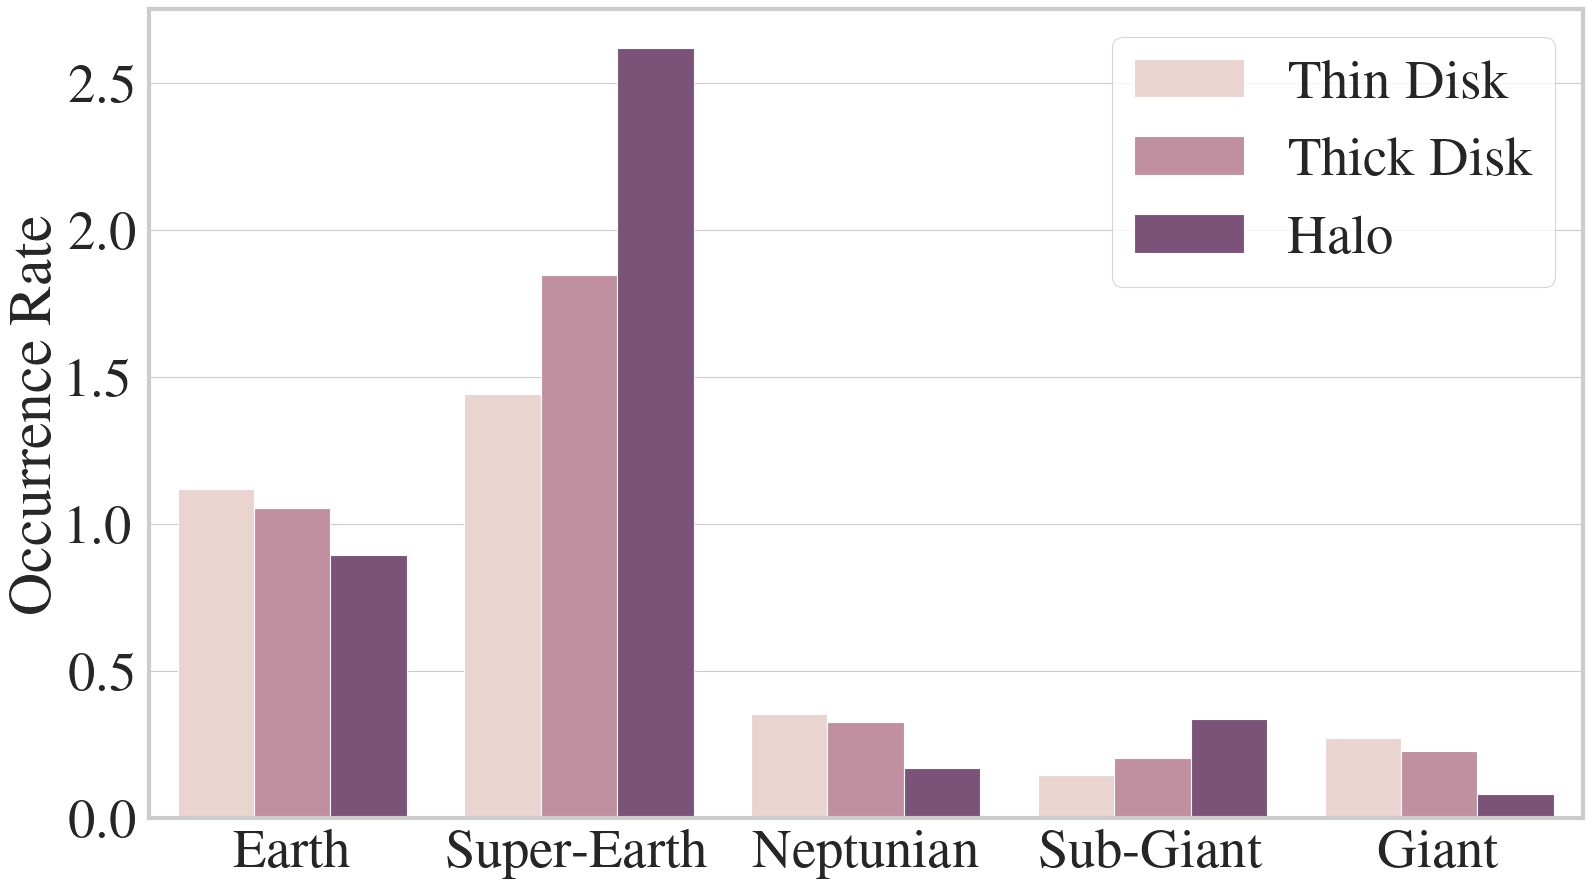

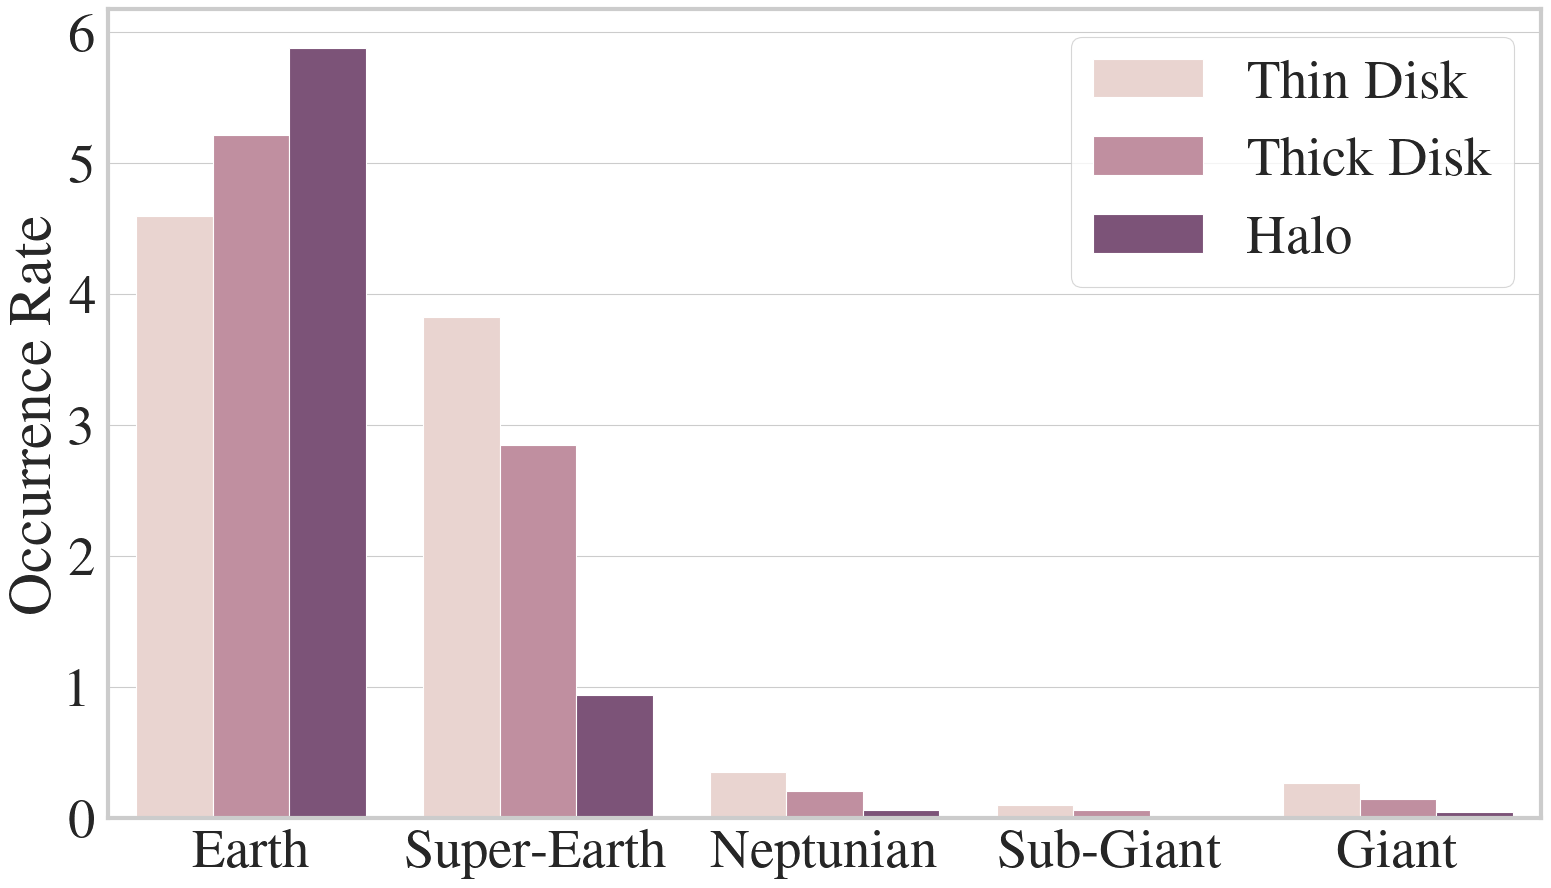

In [13]:
components = ["Thin Disk", "Thick Disk", "Halo"]

for num_embryos in [10, 100]:
    plt.figure()
    occurence_rates = metric_table[num_embryos]["Occurrence Rate"].reset_index()
    occurence_rates.rename(
        columns={"level_0": "Population", "level_1": "Planet Category"}, inplace=True
    )

    occurence_rate_barplot = sns.barplot(
        data=occurence_rates,
        x="Planet Category",
        y="Occurrence Rate",
        hue="Population",
        hue_order=components,
        palette=get_palette(n_colors=4),
    )
    occurence_rate_barplot.set_xlabel("")
    occurence_rate_barplot.legend(title="")

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"occurence_rates_with_N_Embryos={num_embryos}.pdf",
        figure_directory=figure_directory,
        save=save,
    )